In [7]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance
plt.rc('figure', figsize=(8, 5))

In [8]:
def load_file(filename):
    return np.loadtxt(filename, delimiter=" ", usecols=(1,2), dtype='int32', skiprows=6, comments='EOF')

def get_distances(points):
    return np.array([[distance.euclidean(points[x], points[y])
                     for x in range(len(points))] for y in range(len(points))])
    
def init_cycles(points, distances):
    cycle1, cycle2 = [], []
    start_point = np.random.randint(0, len(points))
    cycle1.append(start_point)
    
    start_point2 = np.argmax(distances[start_point, :])
    cycle2.append(start_point2)
    
    remaining = list(range(len(points)))
    remaining.remove(start_point)
    remaining.remove(start_point2)
    
    return cycle1, cycle2, remaining

def score_cycles(distances, remaining , cycle):
    scores = np.array([[distances[cycle[c - 1], r] +  distances[cycle[c], r] - 
                       distances[cycle[c - 1], cycle[c]] for c in range(len(cycle))] for r in remaining])
    return scores        

In [9]:
def display_points(points):
    plt.scatter(points[:, 0], points[:, 1])
    plt.show()
    
def draw_path(points, cycle1, cycle2, save_file=None):
    cycle1.append(cycle1[0])
    cycle2.append(cycle2[0])
    
    c1 = np.array(points[cycle1, :])
    c2 = np.array(points[cycle2, :])
    
    plt.scatter(points[:, 0], points[:, 1], color='black')
    
    plt.plot(c1[:, 0], c1[:, 1], color='blue')
    plt.plot(c2[:, 0], c2[:, 1], color='red')
    if save_file is not None:
        plt.savefig(save_file)
    plt.show()
    del cycle1[-1]
    del cycle2[-1]


def cycle_lenght(distances, cycle):
    return sum(distances[cycle[i], cycle[i+1]] for i in range(len(cycle) - 1))

In [15]:
def greedy_near(points, distances):
    cycle1, cycle2, remaining = init_cycles(points, distances)

    while len(remaining) > 0:
        for cycle in [cycle1, cycle2]:
            point = remaining[np.argmin(distances[cycle[-1], remaining])]
            cycle.append(point)
            remaining.remove(point)

    return cycle1, cycle2

def greedy_cycle(points, distances):
    cycle1, cycle2, remaining = init_cycles(points, distances)
    
    point = remaining[np.argmin(distances[cycle1[-1], remaining])]
    cycle1.append(point)
    remaining.remove(point)
    point = remaining[np.argmin(distances[cycle2[-1], remaining])]
    cycle2.append(point)
    remaining.remove(point)

    while len(remaining) > 0:
        for cycle in [cycle1, cycle2]:
            score = score_cycles(distances, remaining, cycle)
            best_point, best_insert = np.unravel_index(np.argmin(score), score.shape)
            cycle.insert(best_insert, remaining[best_point])
            remaining.remove(remaining[best_point])

    return cycle1, cycle2

def regreat_method(points, distances):
    cycle1, cycle2, remaining = init_cycles(points, distances)
    
    point = remaining[np.argmin(distances[cycle1[-1], remaining])]
    cycle1.append(point)
    remaining.remove(point)
    point = remaining[np.argmin(distances[cycle2[-1], remaining])]
    cycle2.append(point)
    remaining.remove(point)
    
    while len(remaining) > 0:
        for cycle in [cycle1, cycle2]:
            score = score_cycles(distances, remaining, cycle)
            regret = np.diff(np.partition(score, 1)[:,:2]).reshape(-1)
            
            weight = 1.7 * np.min(score, axis=1) - regret
            best_point = np.argmin(weight)
            best_insert = np.argmin(score[best_point])
            cycle.insert(best_insert, remaining[best_point])
            remaining.remove(remaining[best_point])
    
    return cycle1, cycle2

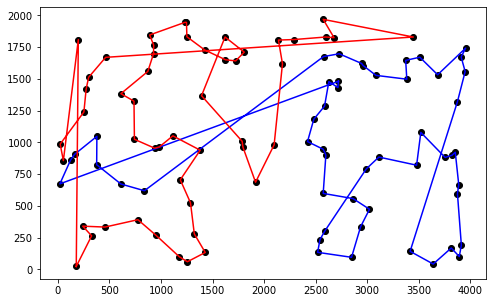

File:  kroA100.tsp 
Heuristic:  greedy_near 
Path lenght: 27409.446738222843


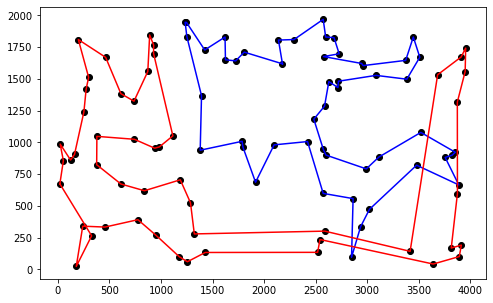

File:  kroA100.tsp 
Heuristic:  greedy_cycle 
Path lenght: 28048.738068262126


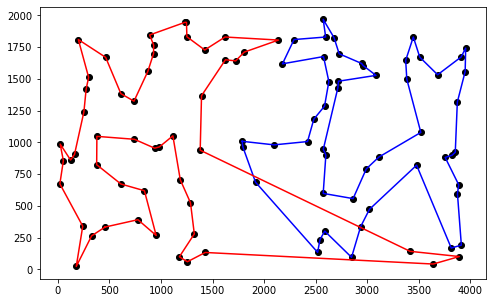

File:  kroA100.tsp 
Heuristic:  regreat_method 
Path lenght: 27728.799691493572


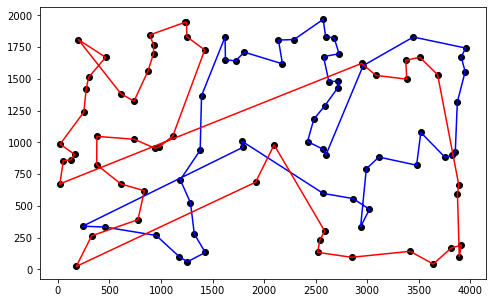

File:  kroB100.tsp 
Heuristic:  greedy_near 
Path lenght: 27076.573940538532


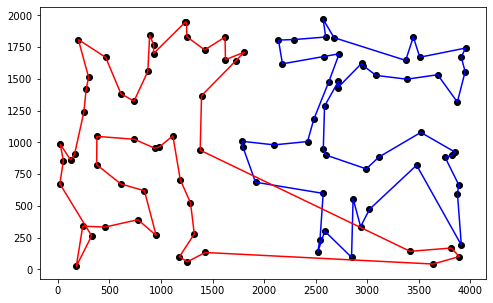

File:  kroB100.tsp 
Heuristic:  greedy_cycle 
Path lenght: 28104.49541469341


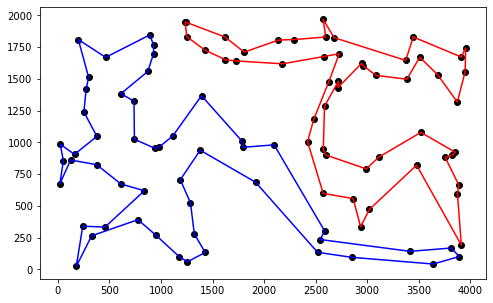

File:  kroB100.tsp 
Heuristic:  regreat_method 
Path lenght: 26805.604572532124


In [5]:
from scipy.spatial import distance
for file in ['kroA100.tsp', 'kroB100.tsp']:
    points = load_file("kroA100.tsp")
    distances = get_distances(points)
    for heuristic in [greedy_near, greedy_cycle, regreat_method]:
        cycle1, cycle2 = heuristic(points, distances)
        heuristic_name = [name for name in globals() if globals()[name] is heuristic][0]
        draw_path(points, cycle1, cycle2, file + "_" + heuristic_name + ".jpg")
        print("File: ", file, "\nHeuristic: ", heuristic_name,
              "\nPath lenght:", cycle_lenght(distances, cycle1) + cycle_lenght(distances, cycle2))

In [16]:
from scipy.spatial import distance
results = {
    ('greedy_near', 'kroA100.tsp')  : [],
    ('greedy_cycle', 'kroA100.tsp') : [],
    ('regreat_method', 'kroA100.tsp'): [],
    ('greedy_near', 'kroB100.tsp')  : [],
    ('greedy_cycle', 'kroB100.tsp') : [],
    ('regreat_method', 'kroB100.tsp'): [], 
}
for x in range(100):
    if x % 10 == 0: 
        print(x)
    for file in ['kroA100.tsp', 'kroB100.tsp']:
        points = load_file("kroA100.tsp")
        distances = get_distances(points)
        for heuristic in [greedy_near, greedy_cycle, regreat_method]:
            cycle1, cycle2 = heuristic(points, distances)
            heuristic_name = [name for name in globals() if globals()[name] is heuristic][0]
            results[(heuristic_name, file)].append(cycle_lenght(distances, cycle1) + cycle_lenght(distances, cycle2))
            
pd.DataFrame(results).describe()            

0
10
20
30
40
50
60
70
80
90


,greedy_near,greedy_cycle,regreat_method,greedy_near,greedy_cycle,regreat_method
,kroA100.tsp,kroA100.tsp,kroA100.tsp,kroB100.tsp,kroB100.tsp,kroB100.tsp
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,27899.220659,28112.360055,26884.114745,27992.955913,28125.583113,27006.700653
std,1414.276444,1002.137593,1585.054270,1287.570738,969.979313,1512.434184
min,23962.924473,25907.375330,23522.151809,23962.924473,25907.375330,23758.788981
25%,26860.162869,27025.406968,25111.118147,27108.418608,27079.236922,26641.998835
50%,28005.387470,28138.059001,27683.298176,28076.328614,28171.164873,27638.941504
75%,28976.138538,29010.375532,28013.453995,28918.409906,29031.953352,27918.393498
max,29960.015873,29663.323084,28663.168153,29960.015873,29663.323084,29861.204149
